# Compressing Data via Dimensionality Reduction

In previous chapter we learned about the different approaches for reducing the dimensionality of a dataset using different feature selection techniques. An alternative approach to feature selection for dimensionality reduction is **feature extraction**. In this chapter, you will learn about three fundamental techniques that will help us to summarize the information content of a dataset by transforming it onto a new feature subspace of lower dimensionality than the original one. Data compression is an important topic in machine learning, and it helps us to store and analyse the increasing amount of data that are produced and collected in the modern age of technology.

In this chapter, we will cover the folloing topics: 
* **Principal Component Analysis (PCA)** for unsupervised data compression. 
* **Linear Discriminant Analysis (LDA)** as a supervised dimensionality reduction technique for maximizing class separability. 
* Non dimensionality reduction via **Kernel Principal Component Analysis (KPCA)**. 

## Unsupervised dimensionality reduction via principal component analysis

Similar to feature selection, we can use different feature extraction techniques to reduce the number of features in the dataset. The difference between feature selection and feature extraction is that while we maintain the original features when we used feature selection algorithms, such as *sequential backward selection*, we use feature extraction to transform or project the data onto a new feature space. In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaning most of the relevant information. In practice, feature extraction is not only used to improve storage space or the computational efficiency of the learning algorithm, but can also improve the predictive performance by reducing the *curse of dimensionality*; especially if we are working with non-regularized models. 

## The main steps behind principal component analysis

In this section, we will discuss PCA, an unsupervised linear transformation technique that is widely used across different fields, most prominently for feature extraction and dimensionality reduction. Other popular applications of PCA include exploratory data analyses and de-noising of signals in stock market trading, and the analysis of genome data and gene expression levels in the field of bioinformatics. 

PCA helps us to identify patters in data based on the correlation between features. In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one. The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance ginve the constraint that the new feature axes are orthogonal to each other, as illustrated in the following figure:

<img src='images/05_01.png'>

In the preceding figure, $x_1$ and $x_2$ are the original features axes and **PC1** and **PC2** are the principal components. 

If we use PCA for dimensionality reduction, we construct a $d \times k$-dimensional transformation matrix **W** that allows us to map a sample vector **x** onto a new $k$-dimensional feature subspace that has fewer dimensions than then original $d$-dimensional feature. 

As a result of transforming the original $d$-dimensional data onto this new $k$-dimensional subspace (typically $k << d$), the first principal component will have the largest possible variance, and all consequent principal component will have the largest variance given the constraint that these components are uncorrelated (orthogonal) to the other principal component; even if the input features are correlated, the resulting principal components will be mutually orthogonal (uncorrelated). Note that the PCA directions are highly sensitive to data scaling, and we need to standardize the features **prior** to PCA if the features were measured on different scales and we want to assign equal importance to all features. 

Before looking at the PCA algorithm for dimensionality reduction in more detail, let's summarize the approach in a few simple steps: 

1. Standardize the $d$-dimensional dataset. 
2. Construct the covariance matrix. 
3. Decompose the covariance matrix into its eigenvectors and eigenvalues. 
4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors. 
5. Select $k$ eigenvectors which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace ($k \le d$).
6. Construct a projection matrix **W** from the "top" $k$ eigenvectors. 
7. Transform the $d$-dimensional input dataset **X** using the projection matrix **W** to obtain the new $k$-dimensional feature subspace. 

In the following sections, we will perform a PCA step by step, using Python as a learning exercise. Then, we will see how perform a PCA more conveniently using scikit-learn. 

## Extracting the principal components step by step

In this subsection, we will tackle the first four steps of a PCA: 

1. Standardize the data. 
2. Constructing the covariance matrix. 
3. Obtaining the eigenvalues and eigenvectors of the covariance matrix. 
4. Sorting the eigenvalues by decreasing order to rank the eigenvectors. 

First, we will start by loading the Wine dataset that we have been working with:

In [1]:
import pandas as pd

df_wine = pd.read_csv('wine.data', header=None)

Next, we will process the Wine data into separate training and test sets; using 70 percent and 30 percent of the data, respectively, and stardardize it to unit variance: 

In [2]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y, random_state=0)
    
# standardize the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

After completing the mandatory preprocessing by executing the preceding code, let's advance to the second step: constructing the covariance matrix. The symmetric $d \times d$-dimensional covariance matrix, where $d$ is the number of dimensions in the dataset, stores the pairwise covariances between the different features. 

A positive covariance between two features indicates that the features increase or decrease together, whereas a negative covariance indicates that the features vary in opposite directions. 

The eigenvectors of the covariance matrix represent the principal components (the directions of maximum variance), whereas the corresponding eigenvalues will define their magnitude. In the case of the Wine dataset, we would obtain 13 eigenvectors and eigenvalues from the $13 \times 13$-dimensional covariance matrix. 

Now, for our third step, let's obtain the eigenpairs of the covariance matrix. Since the manual computation of eigenvectors and eigenvalues is a somewhat tedious and elaborate task, we will use the *linalg.eig* function from NumPy to obtain the eigenpairs of the Wine covariance matrix: 

In [4]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


Using the *numpy.cov* function, we computed the covariance matrix of standardized training dataset. Using the *linalg.eig* function, we performed the eigendecomposition, which yielded a vector (*eigen_vals*) consisting of 13 eigenvalues and the corresponding eigenvectors stored as columns in a $13 \times 13$-dimensional matrix (*eigen_vec*). 

## Total and explained variance

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance). The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top $k$ eigenvectors based on the values of their corresponding eigenvalues. But before we collect those $k$ most informative eigenvectors, let us plot the *variance explained ratios* of the eigenvalues. Using the NumPy *cumsum* function, we can then calculate the cumulative sum of explained variances, which we will then plot via Matplotlib's *step* function: 

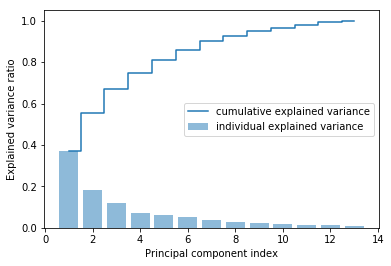

In [6]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid', 
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

The resulting plot indicates that the first principal component alone accounts for approximately 40 percent of the variance. Also, we can see that the first two principal components combined explain almost 60 percent of the variance in the dataset. 

Although the explained variance plot reminds us of the feature importance values that we computed via random forests, we should remind ourselves that PCA is an unsupervised method, which means that information about the class labels are ignored. Whereas a random forest uses the class membership information to compute the node impurities, variance measures the spread of values along the feature axis. 

## Feature transformation

After we have successfully decomposed the covariance matrix into eigenpairs, let's now proceed with the last three steps to transform the Wine dataset onto the new principal component axes. The remaining steps we are going to tackle in this section are the following ones: 
* Select $k$ eigenvectors, which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace ($k \le d$). 
* Construct a project matrix **W** from the "top" $k$ eigenvectors. 
* Transform the $d$-dimensional input dataset **X** using the projection matrix **W** to obtain the new $k$-dimensional feature subspace. 

Or, in less technical terms, we will sort the eigenpairs by descending order of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace. 

We start by sorting the eigenpairs by decreasing order of the eigenvalues:

In [7]:
# Make a list of the (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) 
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

Next, we collect the two eigenvectors that correspond to the two largest eigenvalues, to capture about 60 percent of the variance in this dataset. Note that we only chose two eigenvectors for the purpose of illustration, since we are going to plot the data via a two-dimensional scatter plot later in this subsection. In practice, the number of principal components has to be determined by a trade-off between computational efficiency and the performance of the classifier: 

In [8]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], 
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


By executing the preceding code, we have created a $13 \times 2$-dimensional projection matrix **W** from the top two eigenvectors. 

Using the projection matrix, we can now transform a sample **x** (represented as a $1 \times 13$-dimensional row vector) onto the PCA subspace (the principal components one and two) obtaining $\boldsymbol{x'}$, now a two-dimensional sample vector consisting of two new features: 

In [10]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

Similarly, we can transform the entire $124 \times 13$-dimensional training dataset onto the two principal components by calculating the matrix dot product: 

In [11]:
X_train_pca = X_train_std.dot(w)

Lastly, let us visualize the transformed Wine training set, now stored as an $124 \times 2$-dimensional matrix, in a two-dimensional scatterplot: 

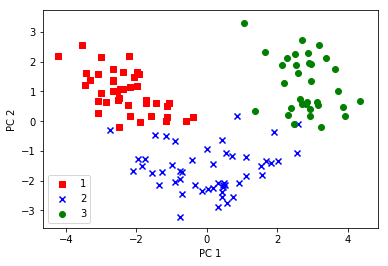

In [12]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

As we can see in the resulting plot, the data is more spread along the *x*-axis; the first principal component; than the second principal component (*y*-axis), which is consistent with the explained variance ratio plot that we created in the previous subsection. However, we can intuitively see that a linear classifier will likely be able to separate the class well. 

Although we encoded the class label information for the purpose of illustration in the preceding scatter plot, we have to keep in mind that PCA is an unsupervised technique that doesn't use any class label information. 

## Principal component analysis in scikit-learn

Although the verbose approach in the previous subsection helped us to follow the inner workings of PCA, we will now discuss how to use the *PCA* class implemented in scikit-learn. The *PCA* class is another one of scikit-learn's transformer classes, where we first fit the model using the training data before we transform both the training and test dataset using the same model paramters. Now, let's use the *PCA* class from scikit-learn on the Wine training dataset, classify the transformed samples via logistic regression, and visualize the decision regions via the *plot_decision_region* function:

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], 
                    alpha=0.6, c=cmap(idx), 
                    edgecolor='black', marker=markers[idx], 
                    label=cl)

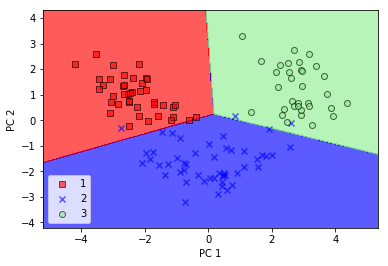

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

When we compare PCA projections via scikit-learn with our own PCA implementation, it can happen that the resulting plots are mirror images of each other. Note that this is not due to an error in either of those two implementations, but the reason of this difference is that, depending on the eigensolver, eigenvectors can have either negative or positive signs. Not that it matters, but we could simply revert the mirror image by multiplying the data by *-1* if we wanted to; note that eigenvectors are typically scaled to unit length 1. For the sake of completeness, let's plot the decision regions of the logistic regression on the transformed test dataset to see if it can separate the classes well:

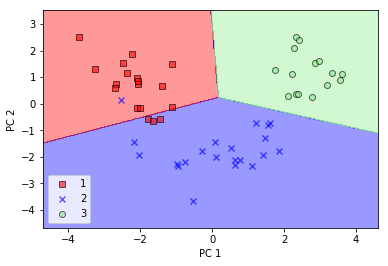

In [17]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

If we are interested in the explained variance ratios of the different principal components, we can simply initialize the *PCA* class with the *n_components* parameter set to *None*, so all principal components are kept and the explained variance ratio can then be accessed via the *explained_variance_ratio_* attribute: 

In [18]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

Note that we set *n_components=None* when we initialized the *PCA* class so that it will return all principal components in a sorted order instead of performing a dimensionality reduction. 